In [1]:
# Imports
%matplotlib inline

# Import statements
import os # for directory operations
import numpy as np # for numerical/linear algebra methods
import pandas as pd # for data(frame) processing
import pdb # for debudding
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for cool plotting
import re # for regular expression
import nltk # natural language processing toolkit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from langdetect import detect, detect_langs # for language detection
from tqdm.notebook import tqdm, trange
import time
import math
from collections import Counter
import spacy
import pickle
import ast
from collections import Counter

In [1]:
# GLOBAL VARIABLES
PLOT_DIMS = (11.7, 8.27)
LABEL_SIZE = 25
TICK_SIZE=20

In [3]:
data = pd.read_csv("metadata/dialogs_metadata.csv")

### NB: Filter-step 1 (i.e., only keep conversations with 2 participants) has been performed already. 

In [4]:
data.head()

,conv_id,n_utterances,n_tokens,topics,type,speaker1_id,speaker1_age_cat,speaker1_gender,speaker1_educ,speaker2_id,speaker2_age_cat,speaker2_gender,speaker2_educ
0,S24A,127,1757,['the art'],"['discussing', 'explaining', 'inquiring']",S0261,40_49,M,4_graduate,S0262,40_49,F,5_postgrad
1,S27D,802,6327,"['health', 'politics', 'finance', 'tv']","['discussing', 'explaining', 'complaining']",S0024,30_39,F,5_postgrad,S0144,30_39,M,5_postgrad
2,S28F,2776,26817,"['menopause', 'reflexology', 'chakra', 'family...","['discussing', 'explaining', 'advising', 'requ...",S0255,40_49,F,4_graduate,S0315,30_39,F,2_secondary
3,S29X,330,2774,"['art course running at the time', 'plus old i...","['discussing', 'explaining', 'inquiring', 'ane...",S0486,60_69,F,4_graduate,S0642,70_79,M,4_graduate
4,S2A5,233,1818,['meeting; making arrangements for going to lo...,['discussing'],S0024,30_39,F,5_postgrad,S0144,30_39,M,5_postgrad


In [5]:
data.describe(include = [np.number])

,n_utterances,n_tokens
count,622.000000,622.000000
mean,736.186495,7752.729904
std,599.829829,5600.593348
min,67.000000,819.000000
25%,333.500000,3835.000000
50%,541.500000,6102.000000
75%,923.500000,10249.250000
max,4859.000000,39575.000000


In [6]:
data.describe(include = ['O'])

,conv_id,topics,type,speaker1_id,speaker1_age_cat,speaker1_gender,speaker1_educ,speaker2_id,speaker2_age_cat,speaker2_gender,speaker2_educ
count,622,622,622,622,622,622,622,622,622,622,622
unique,622,576,195,108,7,2,5,195,11,2,5
top,S9DE,[],"['discussing', 'explaining']",S0024,19_29,F,4_graduate,S0144,19_29,F,5_postgrad
freq,1,13,52,43,241,481,260,43,226,340,275


In [7]:
type(data)

pandas.core.frame.DataFrame

In [8]:
data.shape
# Dataset size after filter step 1 went from 1251 to 622.
# Young vs. elder groups () e.g., 19_29 vs 50+ (maybe 40+?)
# Classify on the dialogue-level or utterance-level?
# Dialogue lengths (no. words, sentences etc.)
# Focus on how much data we have, feasibility

(622, 13)

In [9]:
print(f"Total number of utterances: {sum(data.n_utterances)}.")

Total number of utterances: 457908.


In [10]:
print(f"Total number of tokens: {sum(data.n_tokens)}.")

Total number of tokens: 4822198.


Text(0.5, 1.0, 'Distribution of (speaker 1) age-groups over dialogues.')

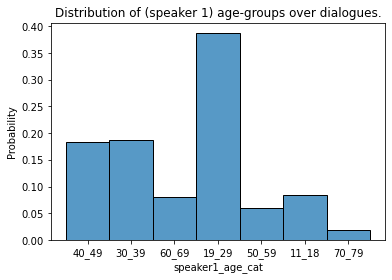

In [11]:
sns.histplot(data, x="speaker1_age_cat", binwidth=3, stat="probability")
plt.title("Distribution of (speaker 1) age-groups over dialogues.")

Text(0.5, 1.0, 'Distribution of (speaker 2) age-groups over dialogues.')

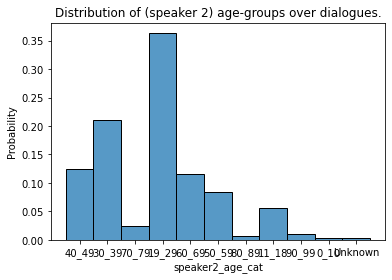

In [12]:
sns.histplot(data, x="speaker2_age_cat", binwidth=3, stat="probability")
plt.title("Distribution of (speaker 2) age-groups over dialogues.")

/Users/lennertjansen/miniconda3/envs/thesis/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


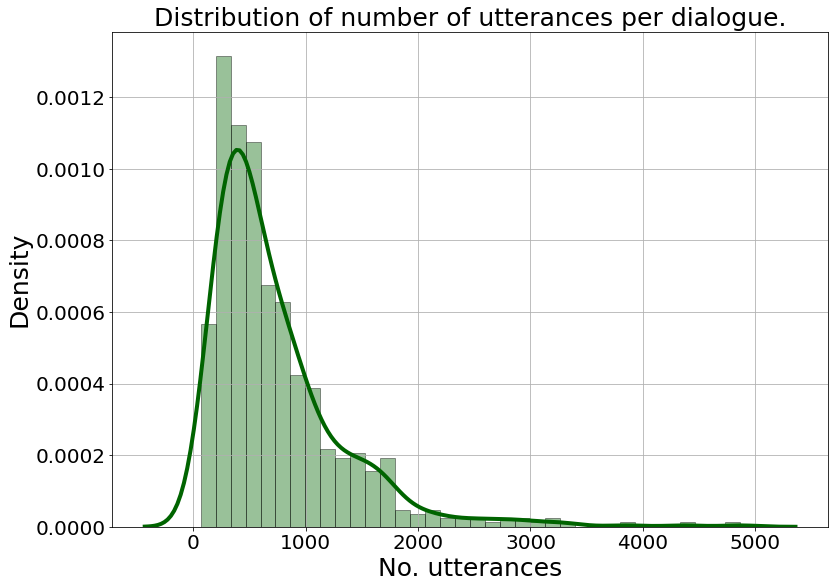

In [13]:
# Density Plot and Histogram of number of utterances per dialogue
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.distplot(data['n_utterances'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkgreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_title("Distribution of number of utterances per dialogue.", size=LABEL_SIZE)
ax.set_xlabel("No. utterances", size=LABEL_SIZE)
ax.set_ylabel("Density", size=LABEL_SIZE)
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
plt.savefig('../../figures/bnc/bnc_utterance_kde.png')

/Users/lennertjansen/miniconda3/envs/thesis/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


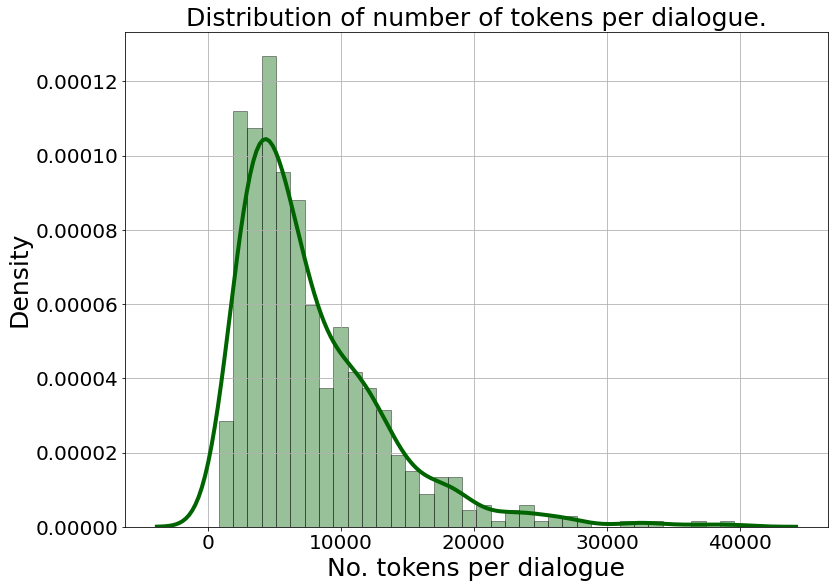

In [14]:
# Density Plot and Histogram of no. tokens per dialogue
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.distplot(data['n_tokens'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkgreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_title("Distribution of number of tokens per dialogue.", size=LABEL_SIZE)
ax.set_xlabel("No. tokens per dialogue", size=LABEL_SIZE)
ax.set_ylabel("Density", size=LABEL_SIZE)
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
plt.savefig('../../figures/bnc/bnc_tokens_kde.png')

In [15]:
data.speaker1_age_cat.unique()

array(['40_49', '30_39', '60_69', '19_29', '50_59', '11_18', '70_79'],
      dtype=object)

In [16]:
data.speaker2_age_cat.unique()

array(['40_49', '30_39', '70_79', '19_29', '60_69', '50_59', '80_89',
       '11_18', '90_99', '0_10', 'Unknown'], dtype=object)

### Filter step 2: remove all dialogues with speaker age category 'unknown', '0_10', or '11_18'

In [17]:
age_cats_to_rm = ['Unknown', '0_10', '11_18']
data.drop(data[data['speaker1_age_cat'].isin(age_cats_to_rm)].index, inplace=True)
data.drop(data[data['speaker2_age_cat'].isin(age_cats_to_rm)].index, inplace=True)

In [18]:
data.speaker2_age_cat.unique()

array(['40_49', '30_39', '70_79', '19_29', '60_69', '80_89', '50_59',
       '90_99'], dtype=object)

In [19]:
data.speaker1_age_cat.unique()

array(['40_49', '30_39', '60_69', '19_29', '50_59', '70_79'], dtype=object)

In [20]:
# dataset size after F.S. 2: 552 (70 removed)
data.shape[0]

552

In [21]:
print(f"Remaining dataset size: {data.shape[0]}.")
print(f'Remaining number of utterances: {sum(data.n_utterances)}.')
print(f'Remaining number of tokens: {sum(data.n_tokens)}.')

Remaining dataset size: 552.
Remaining number of utterances: 417595.
Remaining number of tokens: 4417471.


In [22]:
# Age group counts
data.speaker1_age_cat.value_counts()

19_29    236
30_39    116
40_49    111
60_69     50
50_59     27
70_79     12
Name: speaker1_age_cat, dtype: int64

In [23]:
data.speaker2_age_cat.value_counts()

19_29    225
30_39    131
60_69     70
40_49     61
50_59     41
70_79     15
90_99      6
80_89      3
Name: speaker2_age_cat, dtype: int64

sns.histplot(data, x="speaker1_age_cat", binwidth=3, stat="probability")

#### Preliminary overview of age, gender, and educ. distributions

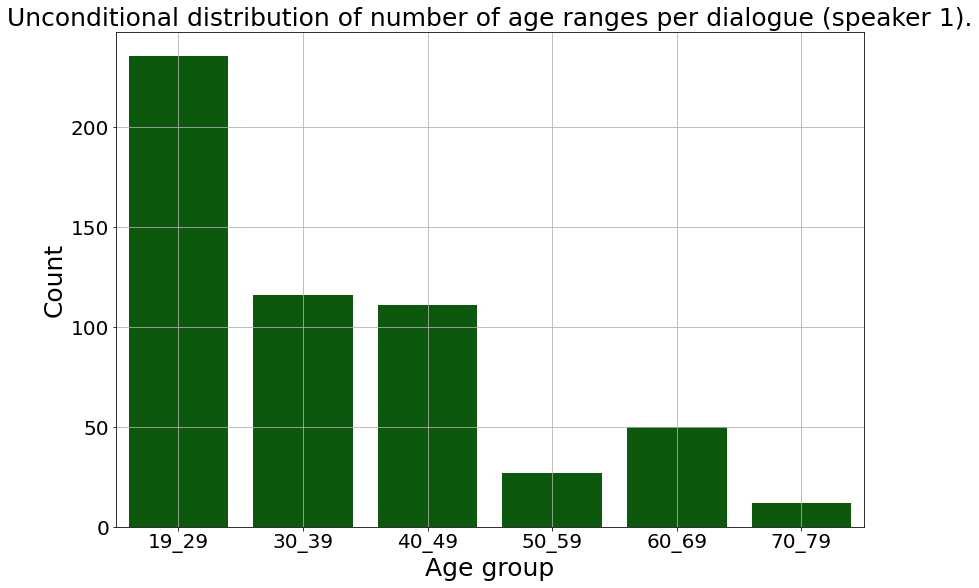

In [24]:
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.countplot(data=data,x='speaker1_age_cat',color = 'darkgreen', order = ['19_29', '30_39', '40_49', '50_59', '60_69', '70_79'])
# def plot_hist(data, x, hue, title, xlabel, ylabel, file_name,kde=False, save=True):
ax.set_title("Unconditional distribution of number of age ranges per dialogue (speaker 1).", size=LABEL_SIZE)
ax.set_xlabel("Age group", size=LABEL_SIZE)
ax.set_ylabel("Count", size=LABEL_SIZE)
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
# plt.savefig('../../figures/bnc/bnc_tokens_kde.png')
plt.show()

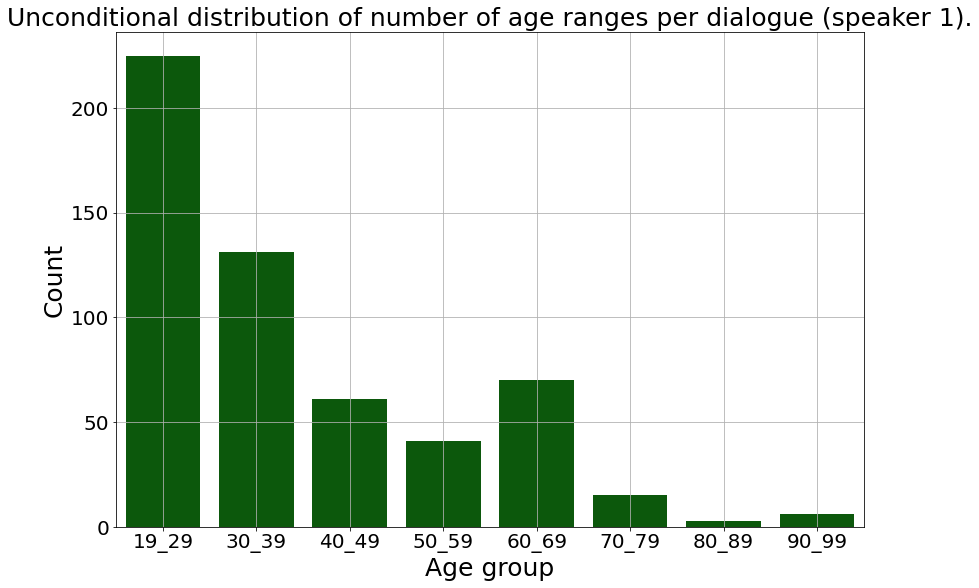

In [25]:

fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.countplot(data=data,x='speaker2_age_cat',color = 'darkgreen', order = ['19_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_99'])
# def plot_hist(data, x, hue, title, xlabel, ylabel, file_name,kde=False, save=True):
ax.set_title("Unconditional distribution of number of age ranges per dialogue (speaker 1).", size=LABEL_SIZE)
ax.set_xlabel("Age group", size=LABEL_SIZE)
ax.set_ylabel("Count", size=LABEL_SIZE)
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
# plt.savefig('../../figures/bnc/bnc_tokens_kde.png')
plt.show()

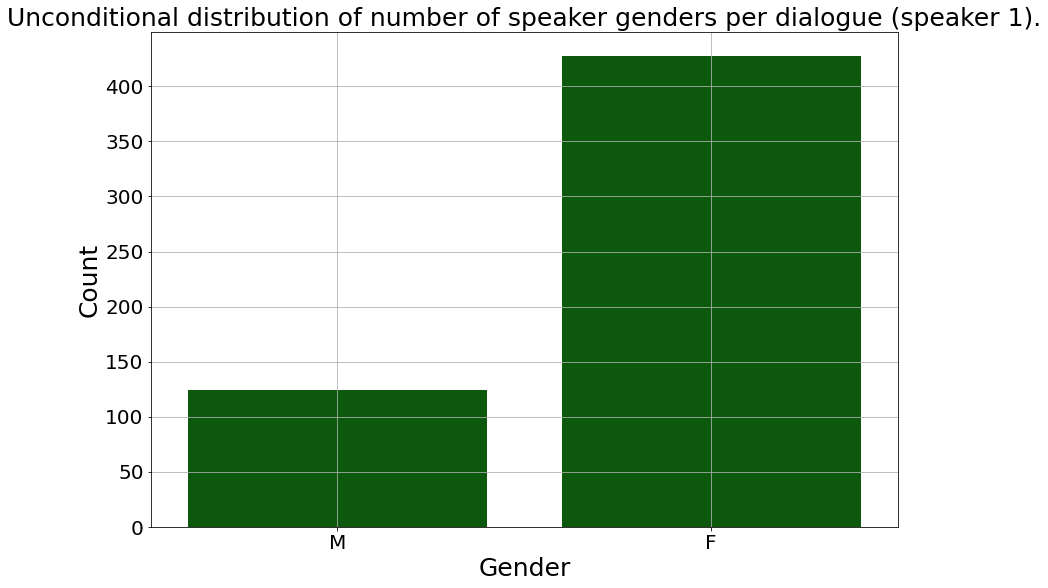

In [26]:
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.countplot(data=data,x='speaker1_gender',color = 'darkgreen')
# def plot_hist(data, x, hue, title, xlabel, ylabel, file_name,kde=False, save=True):
ax.set_title("Unconditional distribution of number of speaker genders per dialogue (speaker 1).", size=LABEL_SIZE)
ax.set_xlabel("Gender", size=LABEL_SIZE)
ax.set_ylabel("Count", size=LABEL_SIZE)
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
# plt.savefig('../../figures/bnc/bnc_tokens_kde.png')
plt.show()

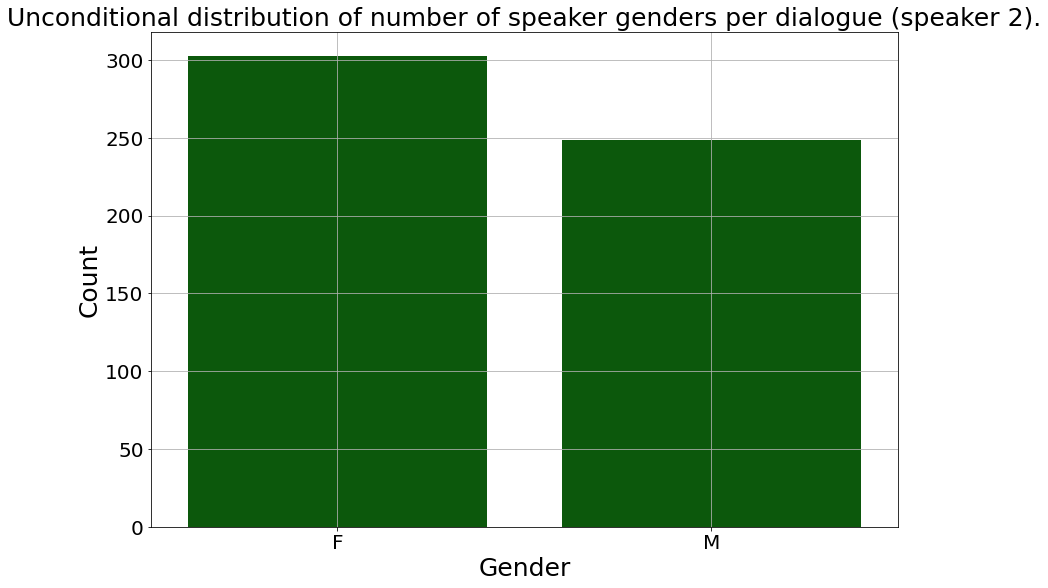

In [27]:
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.countplot(data=data,x='speaker2_gender',color = 'darkgreen')
# def plot_hist(data, x, hue, title, xlabel, ylabel, file_name,kde=False, save=True):
ax.set_title("Unconditional distribution of number of speaker genders per dialogue (speaker 2).", size=LABEL_SIZE)
ax.set_xlabel("Gender", size=LABEL_SIZE)
ax.set_ylabel("Count", size=LABEL_SIZE)
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
# plt.savefig('../../figures/bnc/bnc_tokens_kde.png')
plt.show()

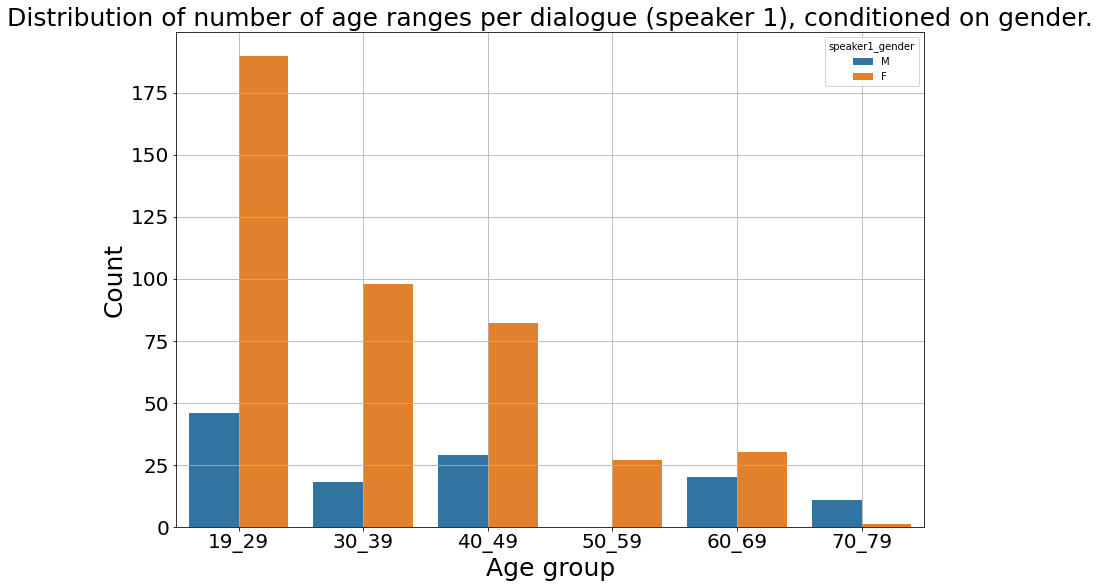

In [28]:
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.countplot(data=data,x='speaker1_age_cat', hue='speaker1_gender', order = ['19_29', '30_39', '40_49', '50_59', '60_69', '70_79'])
# def plot_hist(data, x, hue, title, xlabel, ylabel, file_name,kde=False, save=True):
ax.set_title("Distribution of number of age ranges per dialogue (speaker 1), conditioned on gender.", size=LABEL_SIZE)
ax.set_xlabel("Age group", size=LABEL_SIZE)
ax.set_ylabel("Count", size=LABEL_SIZE)
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
# plt.savefig('../../figures/bnc/bnc_tokens_kde.png')
plt.show()

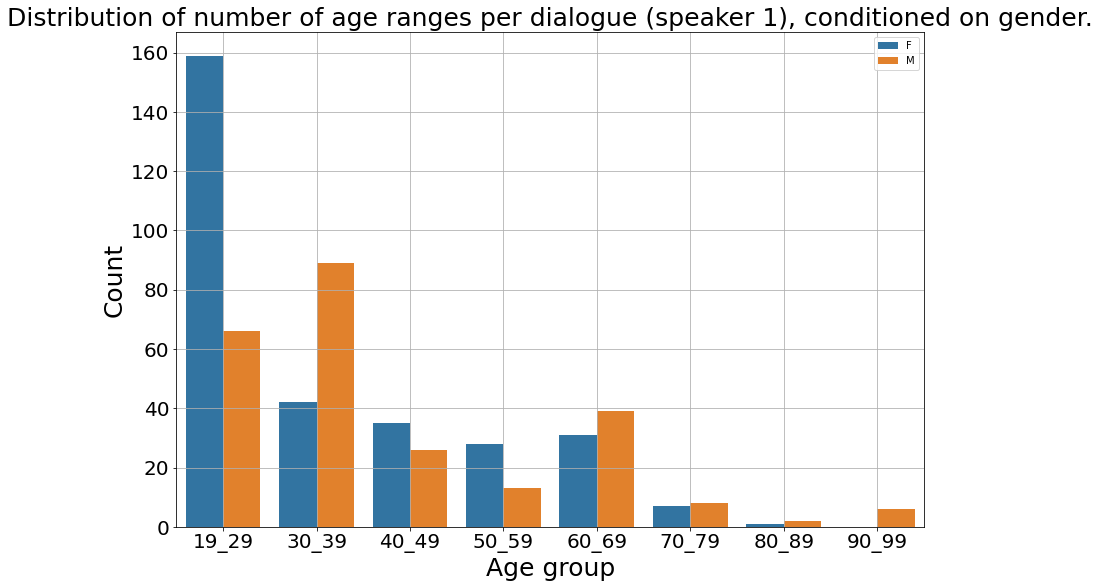

In [29]:
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.countplot(data=data,x='speaker2_age_cat', hue='speaker2_gender', order = ['19_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_99'])
# def plot_hist(data, x, hue, title, xlabel, ylabel, file_name,kde=False, save=True):
ax.set_title("Distribution of number of age ranges per dialogue (speaker 1), conditioned on gender.", size=LABEL_SIZE)
ax.set_xlabel("Age group", size=LABEL_SIZE)
ax.set_ylabel("Count", size=LABEL_SIZE)
ax.legend(loc='upper right')
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
# plt.savefig('../../figures/bnc/bnc_tokens_kde.png')
plt.show()

In [30]:
all_speaker_age_cats = list(data.speaker1_age_cat) + list(data.speaker2_age_cat)
all_speaker_genders = list(data.speaker1_gender) + list(data.speaker2_gender)

/Users/lennertjansen/miniconda3/envs/thesis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


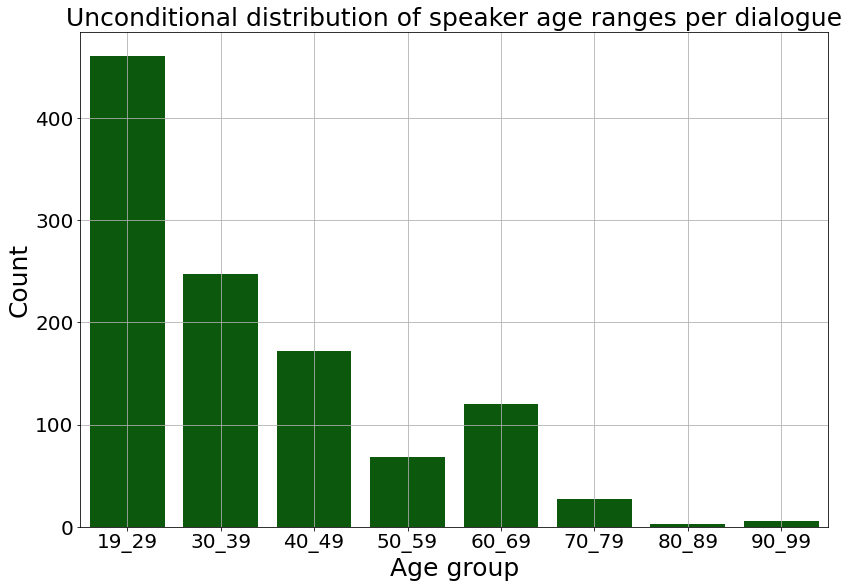

In [31]:
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.countplot(all_speaker_age_cats, color='darkgreen', order = ['19_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_99'])
# def plot_hist(data, x, hue, title, xlabel, ylabel, file_name,kde=False, save=True):
ax.set_title("Unconditional distribution of speaker age ranges per dialogue", size=LABEL_SIZE)
ax.set_xlabel("Age group", size=LABEL_SIZE)
ax.set_ylabel("Count", size=LABEL_SIZE)
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
# plt.savefig('../../figures/bnc/bnc_tokens_kde.png')
plt.show()

/Users/lennertjansen/miniconda3/envs/thesis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


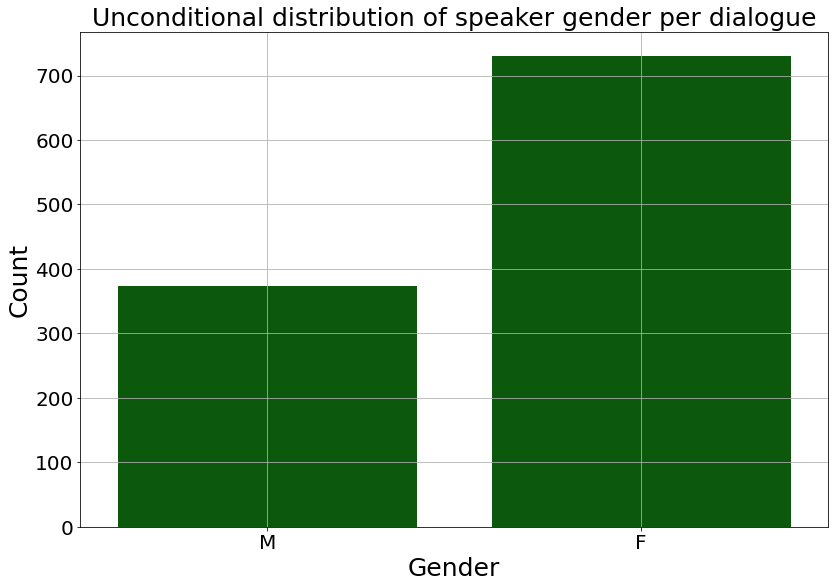

In [32]:
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.countplot(all_speaker_genders, color='darkgreen')
# def plot_hist(data, x, hue, title, xlabel, ylabel, file_name,kde=False, save=True):
ax.set_title("Unconditional distribution of speaker gender per dialogue", size=LABEL_SIZE)
ax.set_xlabel("Gender", size=LABEL_SIZE)
ax.set_ylabel("Count", size=LABEL_SIZE)
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
# plt.savefig('../../figures/bnc/bnc_tokens_kde.png')
plt.show()

#### F.S. 3.0: get overview of all unique age categories between both speakers

In [33]:
Counter(all_speaker_age_cats)

Counter({'40_49': 172,
         '30_39': 247,
         '60_69': 120,
         '19_29': 461,
         '50_59': 68,
         '70_79': 27,
         '80_89': 3,
         '90_99': 6})

In [34]:
Counter(all_speaker_genders)

Counter({'M': 373, 'F': 731})

In [35]:
68+120+27+3+6

224

In [36]:
df_all_speakers = pd.DataFrame({'age_cat':all_speaker_age_cats, 'gender':all_speaker_genders})

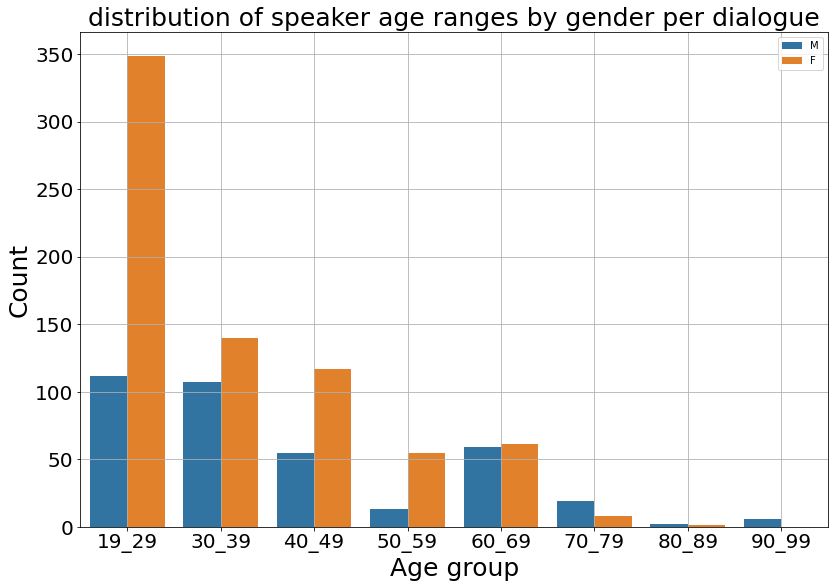

In [37]:
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.countplot(data=df_all_speakers, x='age_cat', hue='gender', order = ['19_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_99'])
# def plot_hist(data, x, hue, title, xlabel, ylabel, file_name,kde=False, save=True):
ax.set_title("distribution of speaker age ranges by gender per dialogue", size=LABEL_SIZE)
ax.set_xlabel("Age group", size=LABEL_SIZE)
ax.set_ylabel("Count", size=LABEL_SIZE)
ax.legend(loc='upper right')
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
plt.savefig('../../figures/bnc/bnc_dist_age_by_gender.png')
plt.show()

In [38]:
pd.crosstab(df_all_speakers['age_cat'], df_all_speakers['gender'])

gender,F,M
age_cat,,
19_29,349,112
30_39,140,107
40_49,117,55
50_59,55,13
60_69,61,59
70_79,8,19
80_89,1,2
90_99,0,6


# Filter step 3a) 19-29 vs. 50+

In [39]:
def age_regroup1(age_cat):
    
    """
    Takes age category and maps to alternate regrouping 1:
    19_29 vs. 50+
    """
    
    if age_cat == '19_29':
        return age_cat
    elif age_cat == '30_39':
        return age_cat
    elif age_cat == '40_49':
        return age_cat
    else:
        return '50_plus'
    
data['speaker1_alt1'] = data.speaker1_age_cat.apply(age_regroup1)
data['speaker2_alt1'] = data.speaker2_age_cat.apply(age_regroup1)

In [40]:
data.head()

,conv_id,n_utterances,n_tokens,topics,type,speaker1_id,speaker1_age_cat,speaker1_gender,speaker1_educ,speaker2_id,speaker2_age_cat,speaker2_gender,speaker2_educ,speaker1_alt1,speaker2_alt1
0,S24A,127,1757,['the art'],"['discussing', 'explaining', 'inquiring']",S0261,40_49,M,4_graduate,S0262,40_49,F,5_postgrad,40_49,40_49
1,S27D,802,6327,"['health', 'politics', 'finance', 'tv']","['discussing', 'explaining', 'complaining']",S0024,30_39,F,5_postgrad,S0144,30_39,M,5_postgrad,30_39,30_39
2,S28F,2776,26817,"['menopause', 'reflexology', 'chakra', 'family...","['discussing', 'explaining', 'advising', 'requ...",S0255,40_49,F,4_graduate,S0315,30_39,F,2_secondary,40_49,30_39
3,S29X,330,2774,"['art course running at the time', 'plus old i...","['discussing', 'explaining', 'inquiring', 'ane...",S0486,60_69,F,4_graduate,S0642,70_79,M,4_graduate,50_plus,50_plus
4,S2A5,233,1818,['meeting; making arrangements for going to lo...,['discussing'],S0024,30_39,F,5_postgrad,S0144,30_39,M,5_postgrad,30_39,30_39


In [41]:
# Drop the non-considered age category, i.e., 30_39
to_rm_alt1 = ['30_39', '40_49']
data_alt1 = data.drop(data[data['speaker1_age_cat'].isin(to_rm_alt1)].index)
data_alt1 = data.drop(data[data['speaker2_age_cat'].isin(to_rm_alt1)].index)

In [42]:
# Consider only dialogues between participants of same (regrouped) age category
data_alt1.drop(data_alt1[data_alt1['speaker1_alt1'] != data_alt1['speaker2_alt1']].index, inplace=True)

In [43]:
print(f"Remaining dataset size: {data_alt1.shape[0]}.")
print(f'Remaining number of utterances: {sum(data_alt1.n_utterances)}.')
print(f'Remaining number of tokens: {sum(data_alt1.n_tokens)}.')

Remaining dataset size: 237.
Remaining number of utterances: 172303.
Remaining number of tokens: 1846503.


/Users/lennertjansen/miniconda3/envs/thesis/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


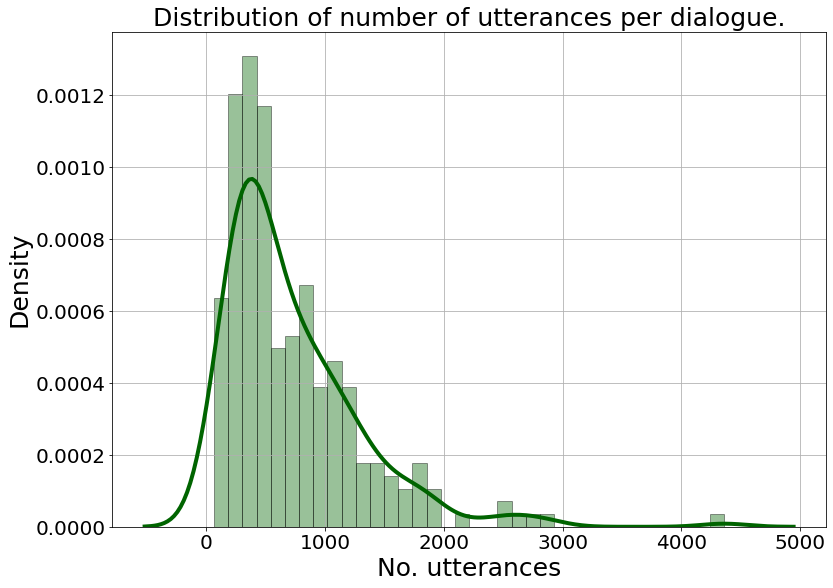

In [44]:
# Density Plot and Histogram of number of utterances per dialogue
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.distplot(data_alt1['n_utterances'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkgreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_title("Distribution of number of utterances per dialogue.", size=LABEL_SIZE)
ax.set_xlabel("No. utterances", size=LABEL_SIZE)
ax.set_ylabel("Density", size=LABEL_SIZE)
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
# plt.savefig('../../figures/bnc/bnc_utterance_kde.png')

/Users/lennertjansen/miniconda3/envs/thesis/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


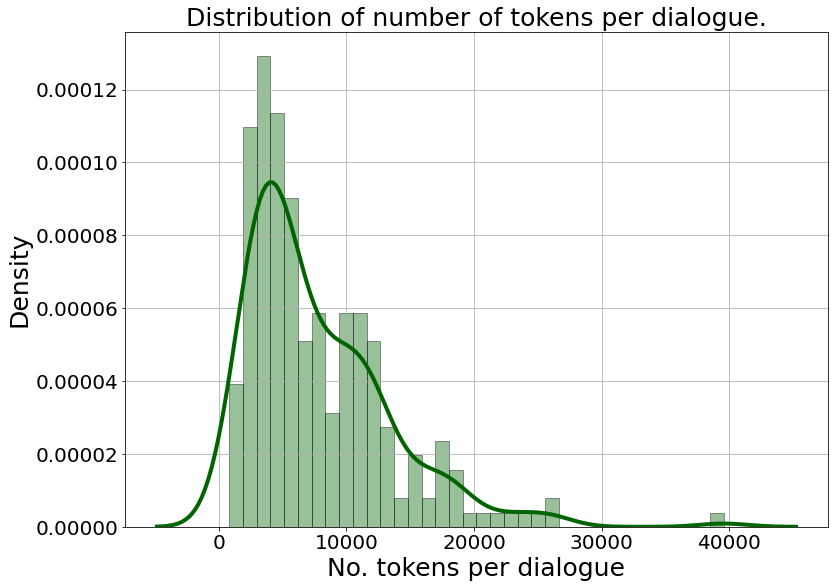

In [45]:
# Density Plot and Histogram of no. tokens per dialogue
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.distplot(data_alt1['n_tokens'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkgreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_title("Distribution of number of tokens per dialogue.", size=LABEL_SIZE)
ax.set_xlabel("No. tokens per dialogue", size=LABEL_SIZE)
ax.set_ylabel("Density", size=LABEL_SIZE)
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
# plt.savefig('../../figures/bnc/bnc_tokens_kde.png')

In [46]:
age_cats_alt1 = list(data_alt1.speaker1_alt1) + list(data_alt1.speaker2_alt1)
genders_alt1 = list(data_alt1.speaker1_gender) + list(data_alt1.speaker2_gender)
df_age_gender_alt1 = pd.DataFrame({'age_cat':age_cats_alt1, 'gender':genders_alt1})

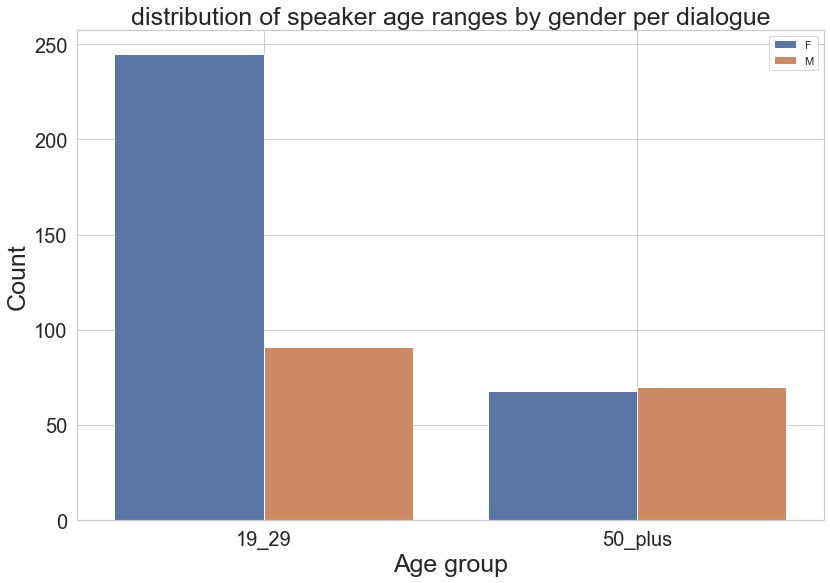

In [63]:
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.countplot(data=df_age_gender_alt1, x='age_cat', hue='gender',order=['19_29', '50_plus'])
# sns.histplot(data=data_alt1, x='speaker1_alt1', stat='probability')
# def plot_hist(data, x, hue, title, xlabel, ylabel, file_name,kde=False, save=True):
ax.set_title("distribution of speaker age ranges by gender per dialogue", size=LABEL_SIZE)
ax.set_xlabel("Age group", size=LABEL_SIZE)
ax.set_ylabel("Count", size=LABEL_SIZE)
ax.legend(loc='upper right')
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
plt.savefig('../../figures/bnc/bnc_alt1_dist_age_by_gender.png')
plt.show()

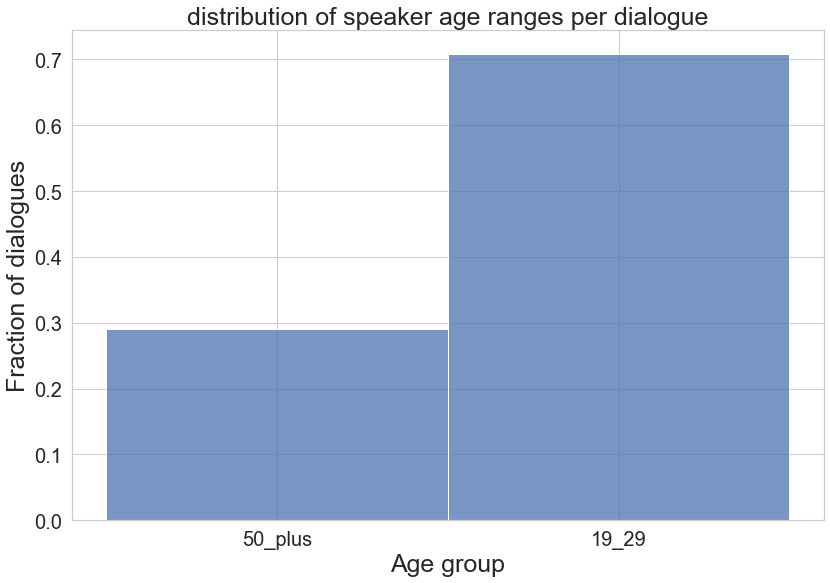

In [60]:
fig, ax = plt.subplots(figsize=PLOT_DIMS)
# sns.set_theme(style="whitegrid") 
# sns.countplot(data=data_alt1, x='speaker1_alt1', order=['19_29', '50_plus'])
sns.histplot(data=data_alt1, x='speaker1_alt1', stat='probability')
# ax.set(ylabel="Percent")
# def plot_hist(data, x, hue, title, xlabel, ylabel, file_name,kde=False, save=True):
ax.set_title("distribution of speaker age ranges per dialogue", size=LABEL_SIZE)
ax.set_xlabel("Age group", size=LABEL_SIZE)
ax.set_ylabel("Fraction of dialogues", size=LABEL_SIZE)
# ax.legend(loc='upper right')
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
plt.savefig('../../figures/bnc/bnc_alt1_dist_age_new.png')
plt.show()

# Filter step 3b) 19-29 vs. 40+


In [48]:
def age_regroup2(age_cat):
    
    """
    Takes age category and maps to alternate regrouping 1:
    19_29 vs. 50+
    """
    
    if age_cat == '19_29':
        return age_cat
    elif age_cat == '30_39':
        return age_cat
    else:
        return '40_plus'
    
data['speaker1_alt2'] = data.speaker1_age_cat.apply(age_regroup2)
data['speaker2_alt2'] = data.speaker2_age_cat.apply(age_regroup2)

In [49]:
# Drop the non-considered age category, i.e., 30_39
to_rm_alt2 = ['30_39']
data_alt2 = data.drop(data[data['speaker1_age_cat'].isin(to_rm_alt2)].index)
data_alt2 = data.drop(data[data['speaker2_age_cat'].isin(to_rm_alt2)].index)

In [50]:
# Consider only dialogues between participants of same (regrouped) age category
data_alt2.drop(data_alt2[data_alt2['speaker1_alt2'] != data_alt2['speaker2_alt2']].index, inplace=True)

In [51]:
print(f"Remaining dataset size: {data_alt2.shape[0]}.")
print(f'Remaining number of utterances: {sum(data_alt2.n_utterances)}.')
print(f'Remaining number of tokens: {sum(data_alt2.n_tokens)}.')

Remaining dataset size: 305.
Remaining number of utterances: 236565.
Remaining number of tokens: 2513164.


In [66]:
age_cats_alt2 = list(data_alt2.speaker1_alt2) + list(data_alt2.speaker2_alt2)
genders_alt2 = list(data_alt2.speaker1_gender) + list(data_alt2.speaker2_gender)
df_age_gender_alt2 = pd.DataFrame({'age_cat':age_cats_alt2, 'gender':genders_alt2})

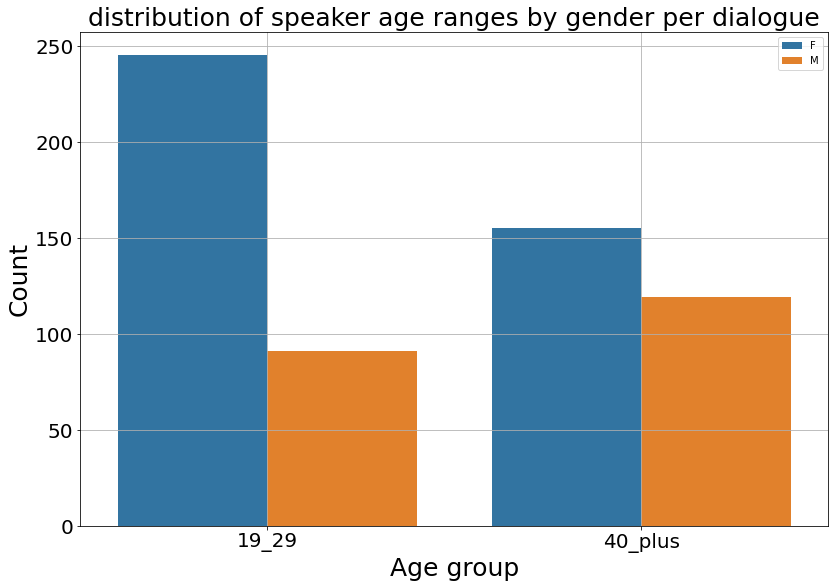

In [82]:
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.countplot(data=df_age_gender_alt2, x='age_cat', hue='gender',order=['19_29', '40_plus'], hue_order=['F', 'M'])
# def plot_hist(data, x, hue, title, xlabel, ylabel, file_name,kde=False, save=True):
ax.set_title("distribution of speaker age ranges by gender per dialogue", size=LABEL_SIZE)
ax.set_xlabel("Age group", size=LABEL_SIZE)
ax.set_ylabel("Count", size=LABEL_SIZE)
ax.legend(loc='upper right')
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
plt.savefig('../../figures/bnc/bnc_alt2_dist_age_by_gender.png')
plt.show()

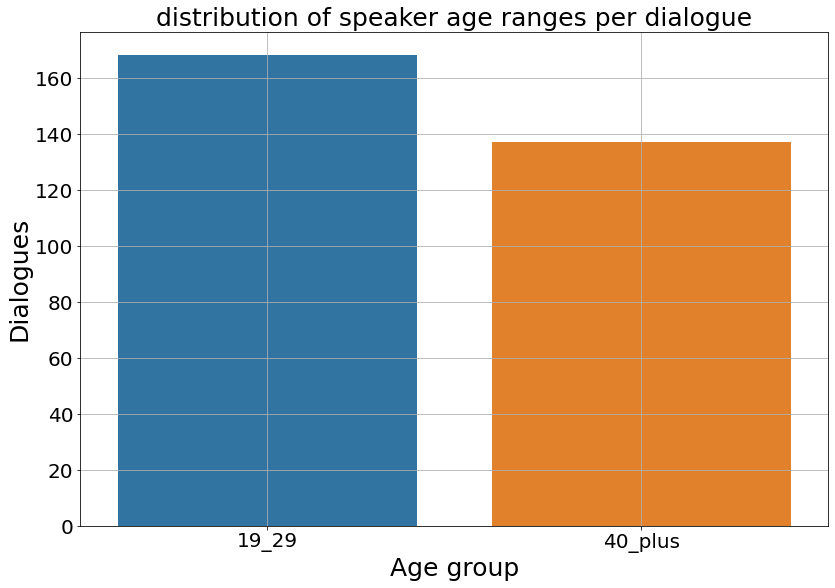

In [83]:
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.countplot(data=data_alt2, x='speaker1_alt2', order=['19_29', '40_plus'])
# def plot_hist(data, x, hue, title, xlabel, ylabel, file_name,kde=False, save=True):
ax.set_title("distribution of speaker age ranges per dialogue", size=LABEL_SIZE)
ax.set_xlabel("Age group", size=LABEL_SIZE)
ax.set_ylabel("Dialogues", size=LABEL_SIZE)
# ax.legend(loc='upper right')
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
plt.savefig('../../figures/bnc/bnc_alt2_dist_age.png')
plt.show()

## Topics

In [86]:
topics_set = set()
all_topics_list = []
topics_counter = Counter
for topic_list in data.topics:
    topic_list = ast.literal_eval(topic_list)
    topic_list = [re.sub(r'[^A-Za-z]+',' ', topic).strip() for topic in topic_list]
    topics_set.update(topic_list)
    all_topics_list = all_topics_list + topic_list

In [87]:
len(topics_set)

1802

In [98]:
# print(topics_set)

In [92]:
topic_counter = Counter(all_topics_list)

In [141]:
# topic_counter.most_common()

In [142]:
len(topic_counter.most_common())

1802

In [145]:
(len(more_than_1_list)/len(topic_counter))* 100

16.9811320754717

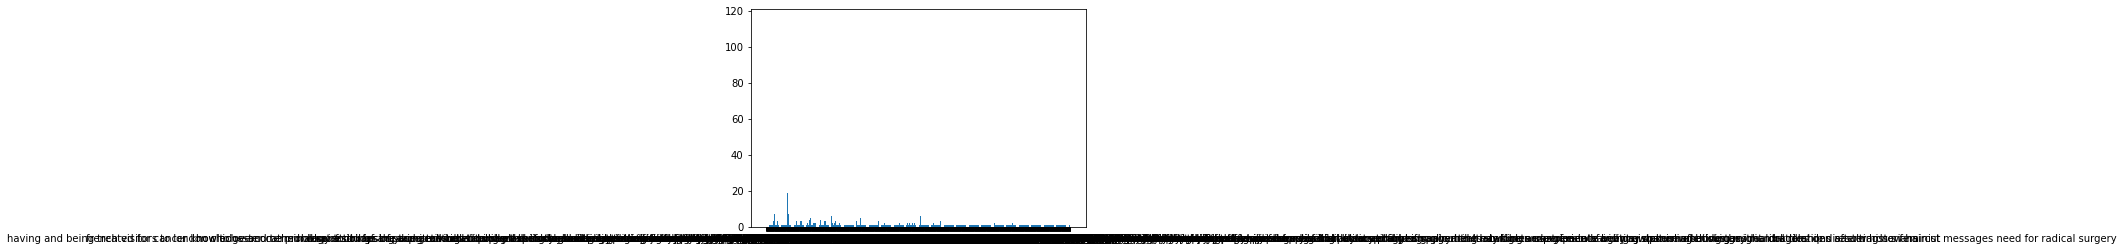

In [97]:
plt.bar(topic_counter.keys(), topic_counter.values())
plt.show()

In [128]:
most_common_list =[('work', 115),
 ('family', 70),
 ('food', 68),
 ('friends', 65),
 ('holidays', 24),
 ('relationships', 23),
 ('cooking', 23),
 ('films', 22),
 ('travel', 21),
 ('sport', 19),
 ('tv', 18),
 ('future plans', 18),
 ('university', 18),
 ('health', 17),
 ('music', 17),
 ('politics', 16),
 ('babies', 16),
 ('UNK', 16),
 ('shopping', 15),
 ('weather', 13),
 ('pets', 13),
 ('driving', 13),
 ('travelling', 12),
 ('football', 12),
 ('jobs', 12),
 ('children', 12),
 ('cars', 12),
 ('education', 11),
 ('bands', 11),
 ('christmas', 11)]

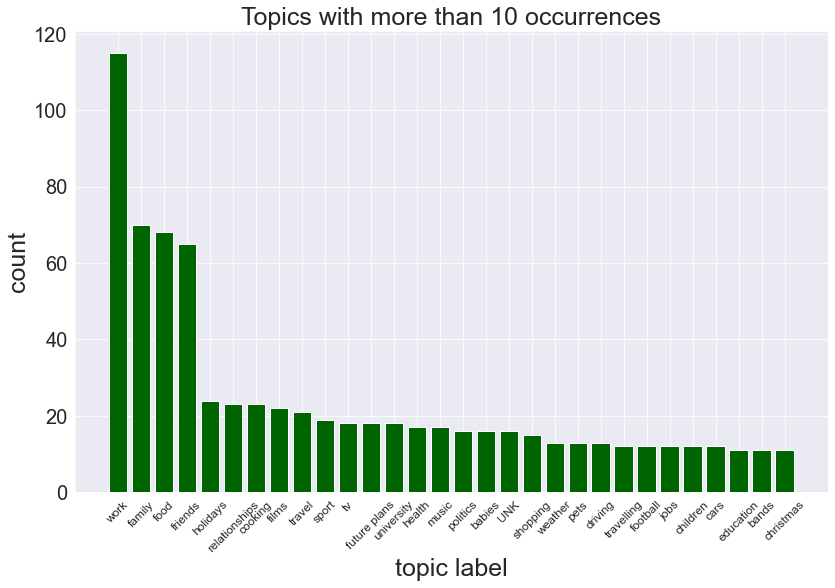

In [139]:
word = []
frequency = []

for i in range(len(most_common_list)):
  word.append(most_common_list[i][0])
  frequency.append(most_common_list[i][1])


indices = np.arange(len(most_common_list))

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=PLOT_DIMS)
plt.bar(indices, frequency, color='darkgreen')
ax.set_title("Topics with more than 10 occurrences", size=LABEL_SIZE)
ax.set_xlabel("topic label", size=LABEL_SIZE)
ax.set_ylabel("count", size=LABEL_SIZE)
# ax.legend(loc='upper right')
plt.setp(ax.get_xticklabels(), fontsize=(TICK_SIZE-8))
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
plt.savefig('../../figures/bnc/bnc_dist_topic_geq_11.png')
plt.xticks(indices, word, rotation=45)
plt.tight_layout()
plt.show()

In [134]:
TICK_SIZE

20

# Topics exploration for BNC Alt1 (19-29 vs. 50+)

In [146]:
alt1_topics_set = set()
alt1_topics_list = []

for topic_list in data_alt1.topics:
    topic_list = ast.literal_eval(topic_list)
    topic_list = [re.sub(r'[^A-Za-z]+',' ', topic).strip() for topic in topic_list]
    alt1_topics_set.update(topic_list)
    alt1_topics_list = alt1_topics_list + topic_list

In [167]:
print(f"The 19-29 vs. 50+ subset has {len(alt1_topics_set)} unique topics.")

The 19-29 vs. 50+ subset has 790 unique topics.


In [166]:
alt1_topic_counter = Counter(alt1_topics_list)

In [173]:
len(alt1_topic_counter)

790

In [199]:
# count=0
# for topic, freq in alt1_topic_counter.most_common():
#     print(topic, freq)
#     count+=1
#     if count > 10:
#         break

In [171]:
# Percentage of topics with more than one occurrence
alt1_topics_1_occ = [(topic, freq) for topic, freq in alt1_topic_counter.most_common() if freq == 1]

In [174]:
print(f"{((len(alt1_topic_counter) - len(alt1_topics_1_occ)) / len(alt1_topic_counter)) * 100}% of topics have more than 1 occurrence.")

16.455696202531644% of topics have more than 1 occurrence.


In [189]:
alt1_topics_10 = [(topic, freq) for topic, freq in alt1_topic_counter.most_common() if freq > 9]

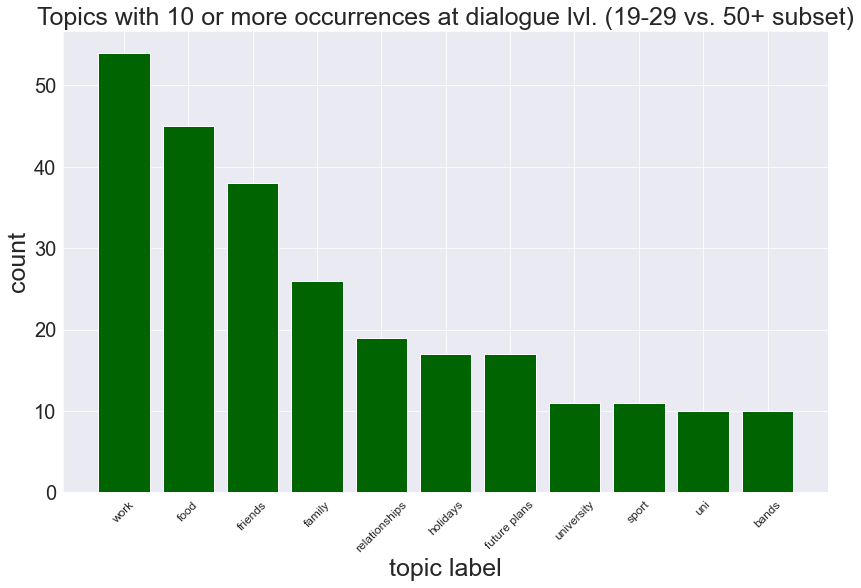

In [191]:
word = []
frequency = []

for i in range(len(alt1_topics_10)):
  word.append(alt1_topics_10[i][0])
  frequency.append(alt1_topics_10[i][1])


indices = np.arange(len(alt1_topics_10))

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=PLOT_DIMS)
plt.bar(indices, frequency, color='darkgreen')
ax.set_title("Topics with 10 or more occurrences at dialogue lvl. (19-29 vs. 50+ subset)", size=LABEL_SIZE)
ax.set_xlabel("topic label", size=LABEL_SIZE)
ax.set_ylabel("count", size=LABEL_SIZE)
# ax.legend(loc='upper right')
plt.setp(ax.get_xticklabels(), fontsize=(TICK_SIZE-8))
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
# plt.savefig('../../figures/bnc/bnc_dist_topic_geq_11.png')
plt.xticks(indices, word, rotation=45)
plt.tight_layout()
plt.show()

### Top topics per age categories

In [193]:
# Find out what the most common topics (and their frequencies) are per age group

# Gather topics by age group (19-29 vs. 50+)
# Young topics (i.e., 19-29)
young_topics_set = set()
young_topics_list = []

for topic_list in data_alt1.loc[data_alt1['speaker1_alt1'] == '19_29'].topics:
    topic_list = ast.literal_eval(topic_list)
    topic_list = [re.sub(r'[^A-Za-z]+',' ', topic).strip() for topic in topic_list]
    young_topics_set.update(topic_list)
    young_topics_list = young_topics_list + topic_list
    
# Old topics (i.e., 50+)
old_topics_set = set()
old_topics_list = []

for topic_list in data_alt1.loc[data_alt1['speaker1_alt1'] == '50_plus'].topics:
    topic_list = ast.literal_eval(topic_list)
    topic_list = [re.sub(r'[^A-Za-z]+',' ', topic).strip() for topic in topic_list]
    old_topics_set.update(topic_list)
    old_topics_list = old_topics_list + topic_list

#### Young (19-29) topics

In [221]:
len(data_alt1)

237

In [208]:
print(f"The 19-29 subset has {len(young_topics_set)} unique topics in {len(data_alt1.loc[data_alt1['speaker1_alt1'] == '19_29'])} dialogues.")
# TODO: What do these numbers say?

The 19-29 subset has 580 unique topics in 168 dialogues.


In [200]:
# Count topic frequencies
young_topic_counter = Counter(young_topics_list)

# Percentage of topics with more than one occurrence
young_topics_1_occ = [(topic, freq) for topic, freq in young_topic_counter.most_common() if freq == 1]
print(f"{((len(young_topic_counter) - len(young_topics_1_occ)) / len(young_topic_counter)) * 100}% of topics have more than 1 occurrence.")

19.655172413793103% of topics have more than 1 occurrence.


In [201]:
# gather topics with 10 or more occurrences in list
young_topics_10 = [(topic, freq) for topic, freq in young_topic_counter.most_common() if freq > 9]

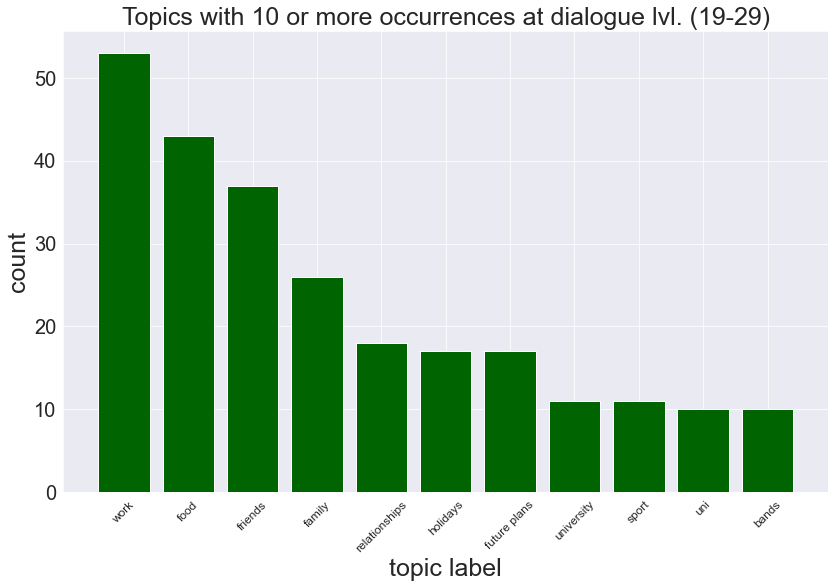

In [202]:
young_word = []
young_frequency = []

for i in range(len(young_topics_10)):
  young_word.append(young_topics_10[i][0])
  young_frequency.append(young_topics_10[i][1])


young_indices = np.arange(len(young_topics_10))

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=PLOT_DIMS)
plt.bar(young_indices, young_frequency, color='darkgreen')
ax.set_title("Topics with 10 or more occurrences at dialogue lvl. (19-29)", size=LABEL_SIZE)
ax.set_xlabel("topic label", size=LABEL_SIZE)
ax.set_ylabel("count", size=LABEL_SIZE)
# ax.legend(loc='upper right')
plt.setp(ax.get_xticklabels(), fontsize=(TICK_SIZE-8))
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
# plt.savefig('../../figures/bnc/bnc_dist_topic_geq_11.png')
plt.xticks(young_indices, young_word, rotation=45)
plt.tight_layout()
plt.show()

#### Old topics

In [222]:
print(f"The 50+ subset has {len(old_topics_set)} unique topics in {len(data_alt1.loc[data_alt1['speaker1_alt1'] == '50_plus'])} dialogues.")
# TODO: What do these numbers say?

The 50+ subset has 231 unique topics in 69 dialogues.


In [210]:
# Count topic frequencies
old_topic_counter = Counter(old_topics_list)

# Percentage of topics with more than one occurrence
old_topics_1_occ = [(topic, freq) for topic, freq in old_topic_counter.most_common() if freq == 1]
print(f"{((len(old_topic_counter) - len(old_topics_1_occ)) / len(old_topic_counter)) * 100}% of topics have more than 1 occurrence.")

4.329004329004329% of topics have more than 1 occurrence.


In [214]:
# old_topic_counter.most_common()

In [217]:
# gather topics with more than 10 occurrences in list
old_topics_1 = [(topic, freq) for topic, freq in old_topic_counter.most_common() if freq > 1]

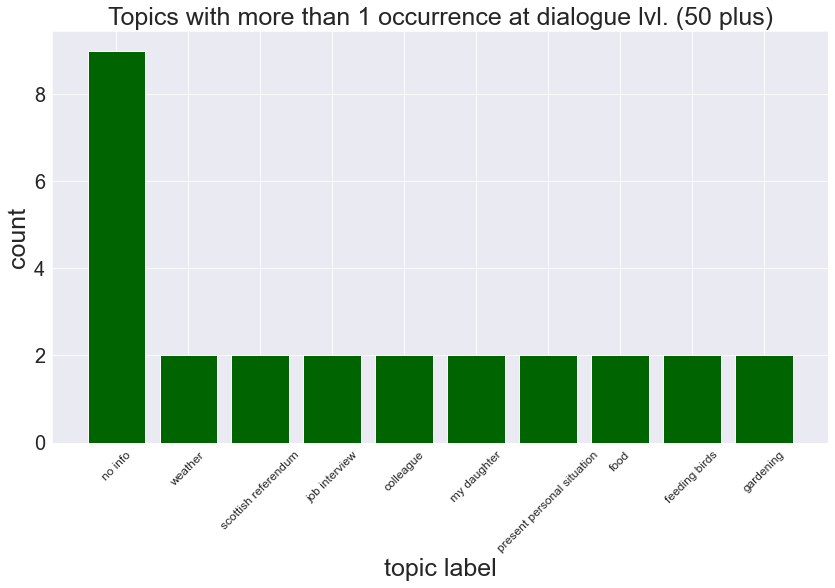

In [220]:
old_word = []
old_frequency = []

for i in range(len(old_topics_1)):
  old_word.append(old_topics_1[i][0])
  old_frequency.append(old_topics_1[i][1])


old_indices = np.arange(len(old_topics_1))

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=PLOT_DIMS)
plt.bar(old_indices, old_frequency, color='darkgreen')
ax.set_title("Topics with more than 1 occurrence at dialogue lvl. (50 plus)", size=LABEL_SIZE)
ax.set_xlabel("topic label", size=LABEL_SIZE)
ax.set_ylabel("count", size=LABEL_SIZE)
# ax.legend(loc='upper right')
plt.setp(ax.get_xticklabels(), fontsize=(TICK_SIZE-8))
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
# plt.savefig('../../figures/bnc/bnc_dist_topic_geq_11.png')
plt.xticks(old_indices, old_word, rotation=45)
plt.tight_layout()
plt.show()

## Other variables, e.g., educ etc.

In [225]:
data_alt1.columns

Index(['conv_id', 'n_utterances', 'n_tokens', 'topics', 'type', 'speaker1_id',
       'speaker1_age_cat', 'speaker1_gender', 'speaker1_educ', 'speaker2_id',
       'speaker2_age_cat', 'speaker2_gender', 'speaker2_educ', 'speaker1_alt1',
       'speaker2_alt1'],
      dtype='object')

In [246]:
print(data.speaker1_educ.unique())
educ_order = ['2_secondary', '3_sixthform', '4_graduate', '5_postgrad', '9_unknown']
print(data.speaker2_educ.unique())

['4_graduate' '5_postgrad' '3_sixthform' '2_secondary' '9_unknown']
['5_postgrad' '2_secondary' '4_graduate' '3_sixthform' '9_unknown']


In [233]:
alt1_educs = list(data_alt1.speaker1_educ) + list(data_alt1.speaker2_educ)
alt1_age_cats = list(data_alt1.speaker1_alt1) + list(data_alt1.speaker2_alt1)
alt1_genders = list(data_alt1.speaker1_gender) + list(data_alt1.speaker2_gender)
df_alt1_age_gender_educ = pd.DataFrame({'age_cat':alt1_age_cats, 'gender':alt1_genders, 'educ' : alt1_educs})

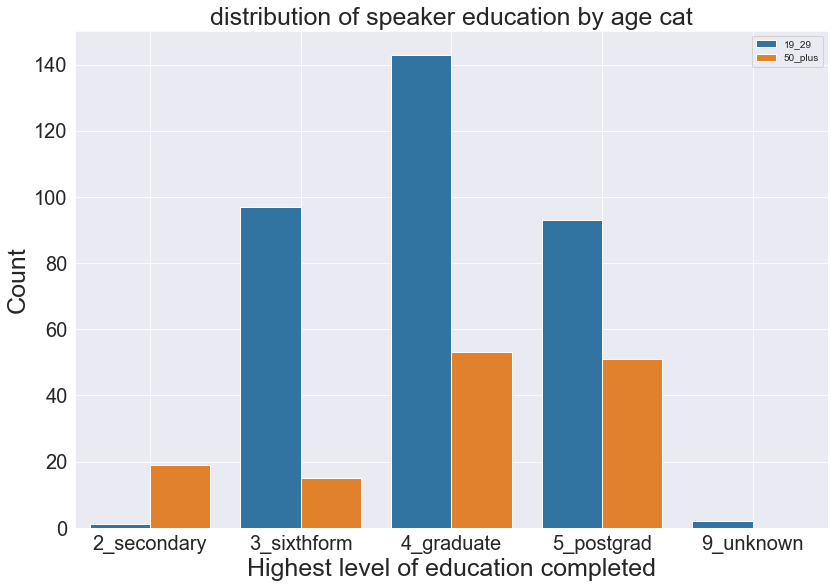

In [254]:
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.countplot(data=df_alt1_age_gender_educ, x='educ', order = educ_order, hue='age_cat',hue_order=['19_29', '50_plus'])
# def plot_hist(data, x, hue, title, xlabel, ylabel, file_name,kde=False, save=True):
ax.set_title("distribution of speaker education by age cat", size=LABEL_SIZE)
ax.set_xlabel("Highest level of education completed", size=LABEL_SIZE)
ax.set_ylabel("Count", size=LABEL_SIZE)
ax.legend(loc='upper right')
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
plt.savefig('../../figures/bnc/bnc_alt1_dist_educ_by_age.png')
plt.show()

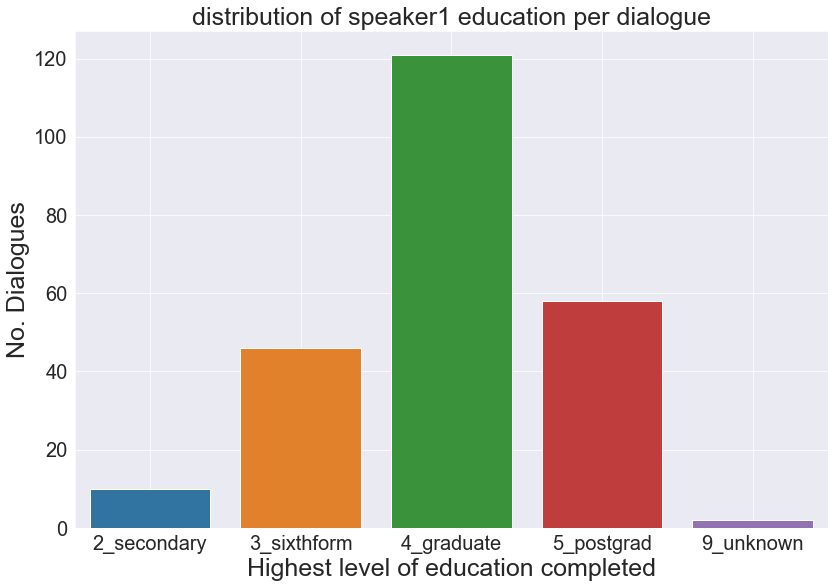

In [256]:
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.countplot(data=data_alt1, x='speaker1_educ', order = educ_order)
# def plot_hist(data, x, hue, title, xlabel, ylabel, file_name,kde=False, save=True):
ax.set_title("distribution of speaker1 education per dialogue", size=LABEL_SIZE)
ax.set_xlabel("Highest level of education completed", size=LABEL_SIZE)
ax.set_ylabel("No. Dialogues", size=LABEL_SIZE)
# ax.legend(loc='upper right')
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
plt.savefig('../../figures/bnc/bnc_alt1_dist_speaker1_educ.png')
plt.show()

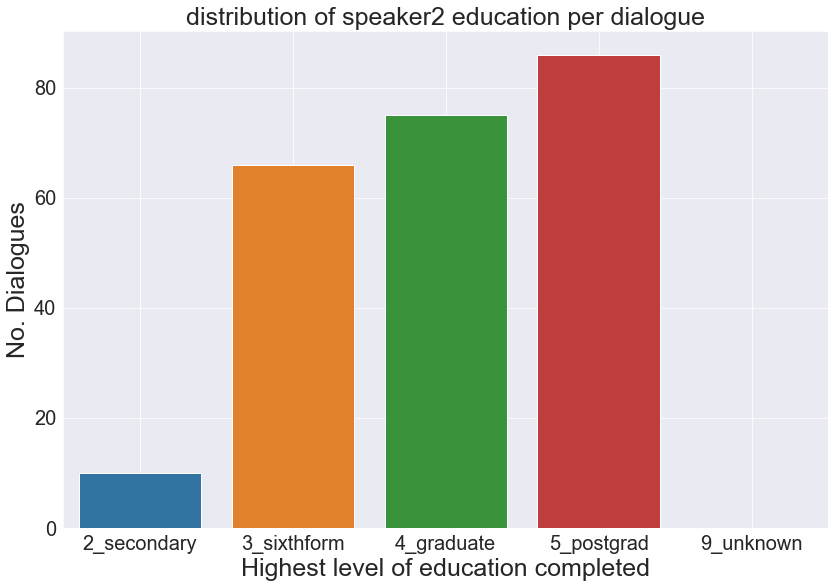

In [257]:
fig, ax = plt.subplots(figsize=PLOT_DIMS)
sns.countplot(data=data_alt1, x='speaker2_educ', order = educ_order)
# def plot_hist(data, x, hue, title, xlabel, ylabel, file_name,kde=False, save=True):
ax.set_title("distribution of speaker2 education per dialogue", size=LABEL_SIZE)
ax.set_xlabel("Highest level of education completed", size=LABEL_SIZE)
ax.set_ylabel("No. Dialogues", size=LABEL_SIZE)
# ax.legend(loc='upper right')
plt.setp(ax.get_xticklabels(), fontsize=TICK_SIZE)
plt.setp(ax.get_yticklabels(), fontsize=TICK_SIZE)
plt.grid(True)
plt.tight_layout()
plt.savefig('../../figures/bnc/bnc_alt1_dist_speaker2_educ.png')
plt.show()